In [2]:
# Useful functions to use:
# skimage.draw.line_nd
# numpy.convolve
# jpg i dicom
#TODO przetwarzanie obrazu stożkowo, 90-270 na 4    50%
#TODO 90-720 x, miary zgodności y
#TODO filtrowanie

In [7]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

In [8]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [9]:
import pydicom

# Use this file as a wireframe while constructing a new DICOM file
REFERENCE_DICOM = 'dicom/Kolo.dcm'
def loadDicom(filename):
    ds = pydicom.dcmread(filename)
    imageData = ds.pixel_array
    image = imageData / np.max(imageData)

    patName = ds.PatientName
    displayName = patName.given_name + " " + patName.family_name
    comment = ds.ImageComments
    acquisitionDate = ds.get('AcquisitionDate', None)

    metadata = (displayName, comment, acquisitionDate)
    return image, metadata

def saveDicom(filename, image, metadata):
    imageData = (image * 255).astype(np.uint8)

    ds = pydicom.dcmread(REFERENCE_DICOM)
    ds.PixelData = imageData.tobytes()
    ds.Rows, ds.Columns = imageData.shape

    patName = metadata[0].split(' ', maxsplit=1)
    ds.PatientName = patName[1] + '^' + patName[0]
    ds.ImageComments = metadata[1]
    ds.AcquisitionDate = metadata[2]
    ds.save_as(filename, write_like_original=False)


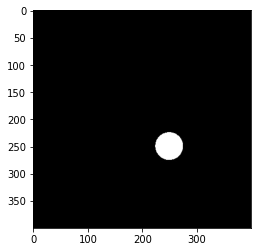

In [10]:
image = loadImage('images/Kropka.jpg')
showImage(image)

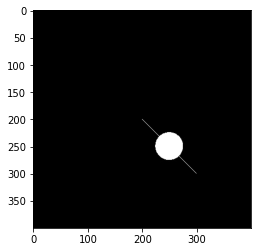

In [11]:
l = ski.draw.line_nd((200, 200), (300, 300))
image[l] = 1
showImage(image)
saveImage(image, 'Kropka.png')

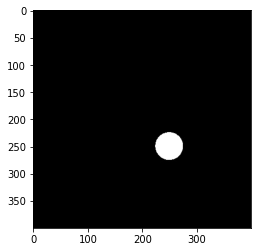

('John Doe', 'what a lovely image we have here...', None)


In [12]:
dicomImage, metadata = loadDicom('dicom/Kropka.dcm')
showImage(dicomImage)
print(metadata)

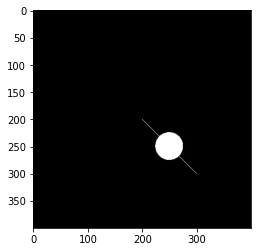

In [13]:
l = ski.draw.line_nd((200, 200), (300, 300))
dicomImage[l] = 1
showImage(dicomImage)
saveDicom('Kropka.dcm', dicomImage, (metadata[0], 'Kropka', '20230304'))

# Image processing
### Radon transform

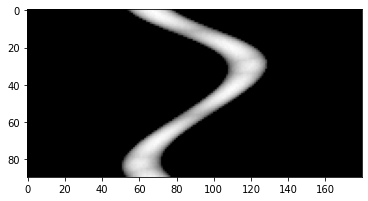

In [116]:
# Performs a Radon transform on an image
# image: 2D array (floats in range [0, 1])
# detectors: number of detectors (equally spaced on an arc)
# scans: number of samples to take (emitter positions equally spaced around the circle)
# detectingAngle: angle of the arc (in degrees) with detectors
def radonTransform(image, detectors = 180, scans = 90, detectingAngle = 180):
	center = np.array(image.shape) // 2     # Center of the emitter-detector system
	radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
	radonImage = np.zeros((scans, detectors), dtype=image.dtype)
	phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
	
	# Where to place the emitter in subsequent scans
	scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detectorAngleGap = phi / (detectors - 1)
	for i, angle in enumerate(scanAngles):
		
		E = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		for j in range(detectors):
			# Where to place the j-th detector
			detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
			D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

			# Make a line between the emitter and the detector
			# And ensure it is in bounds of the image
			y, x = ski.draw.line_nd(E, D)
			inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < image.shape[0])
			line = (y[inBounds], x[inBounds])
			# Average the values of the image along the line
			radonImage[i, j] = np.average(image[line])
	return radonImage

image = loadImage('images/Kropka.jpg')
radonImage = radonTransform(image)
showImage(radonImage)

before


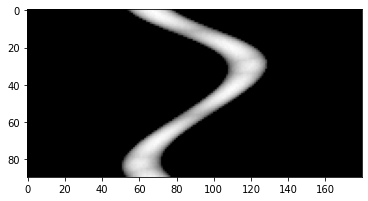

after


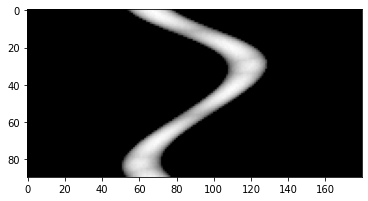

In [136]:
from functools import partial
from scipy import fft
from skimage.transform import rotate
from copy import deepcopy

def inverseRadonTransform2(radonImage, theta=180, detectors = 90, scanAngles = 180):
	scanAngles = np.linspace(0, 2 * np.pi, scanAngles, endpoint=False)
	image = np.zeros((radonImage.shape[1],radonImage.shape[1]))
	width = image.shape[0]
	verse = radonImage[0]
	verse2 = radonImage[1]
	for i in range(width):
		# print(len(verse), len(image[i]))
		image[i] = deepcopy(verse)
	for i in range(width):
		image[i]
	print(scanAngles)
	showImage(image)  


	phi = np.deg2rad(scanAngles)        # Span of the detectors arc
	detectorAngleGap = phi / (detectors - 1)   
		
	dTheta = theta / radonImage.shape[0]
	for i in range(radonImage.shape[0]):
		temp = np.tile(radonImage[i],(radonImage.shape[1],1))
		temp = rotate(temp, dTheta*i)
		image += temp
	return image


def inverseRadonTransform(radonImage, detectors = 180, scans = 90, detectingAngle = 180):
	center = np.array(radonImage.shape) // 2     # Center of the emitter-detector system
	radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
	invRadonImage = np.zeros((scans, detectors), dtype=radonImage.dtype)
	phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
	
	# Where to place the emitter in subsequent scans
	scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detectorAngleGap = phi / (detectors - 1)
	for i, angle in enumerate(scanAngles):
		
		E = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		for j in range(detectors):
			# Where to place the j-th detector
			detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
			D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

			# Make a line between the emitter and the detector
			# And ensure it is in bounds of the image
			y, x = ski.draw.line_nd(E, D)
			inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < radonImage.shape[0])
			line = (y[inBounds], x[inBounds])
			# Average the values of the image along the line
			invRadonImage[i, j] += radonImage[i, j]
	return invRadonImage


def iradon(radon_image, theta=None, output_size=None, filter_name="ramp", interpolation="linear", circle=True, preserve_range=True):
	if theta is None:
		theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)
	angles_count = len(theta)

	interpolation_types = ('linear', 'nearest', 'cubic')

	filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)

	radon_image = convert_to_float(radon_image, preserve_range)
	dtype = radon_image.dtype

	img_shape = radon_image.shape[0]
	if output_size is None:
		# If output size not specified, estimate from input radon image
		if circle:
			output_size = img_shape
		else:
			output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

	if circle:
		radon_image = _sinogram_circle_to_square(radon_image)
		img_shape = radon_image.shape[0]

	# Resize image to next power of two (but no less than 64) for
	# Fourier analysis; speeds up Fourier and lessens artifacts
	projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
	pad_width = ((0, projection_size_padded - img_shape), (0, 0))
	img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

	# Apply filter in Fourier domain
	fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
	projection = fft(img, axis=0) * fourier_filter
	radon_filtered = np.real(fft.ifft(projection, axis=0)[:img_shape, :])

	# Reconstruct image by interpolation
	reconstructed = np.zeros((output_size, output_size),
							 dtype=dtype)
	radius = output_size // 2
	xpr, ypr = np.mgrid[:output_size, :output_size] - radius
	x = np.arange(img_shape) - img_shape // 2

	for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
		t = ypr * np.cos(angle) - xpr * np.sin(angle)
		if interpolation == 'linear':
			interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
		else:
			interpolant = interp1d(x, col, kind=interpolation,
								   bounds_error=False, fill_value=0)
		reconstructed += interpolant(t)

	if circle:
		out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
		reconstructed[out_reconstruction_circle] = 0.

	return reconstructed * np.pi / (2 * angles_count)


# final result
print("before")
image = loadImage('images/Kropka.jpg')
radonImage = radonTransform(image)
showImage(radonImage)

print("after")
invRadonTransform = inverseRadonTransform(radonImage)

showImage(invRadonTransform)

[[1.2246467991473532e-14, -3.4904812874566953, -6.979899340500191, -10.467191248588769, -13.951294748825067, -17.431148549531645, -20.90569265353071, -24.373868681029474, -27.83462019201307, -31.286893008046164, -34.72963553338606, -38.16179907530896, -41.58233816355187, -44.990210868773005, -48.384379119933556, -51.76380902050417, -55.12747116339981, -58.47434094454733, -61.80339887498947, -65.11363089143133, -68.40402866513374, -71.67358990906006, -74.92131868318242, -78.14622569785476, -81.34732861516005, -84.52365234813986, -87.6742293578155, -90.79809994790935, -93.89431255717818, -96.9619240492674, -99.99999999999996, -103.00761498201085, -105.98385284664096, -108.92780700300541, -111.83858069414934, -114.71528727020923, -117.5570504584946, -120.36300463040968, -123.13229506513166, -125.86407820996746, -128.55752193730788, -131.21180579810144, -133.82612127177165, -136.39967201249968, -138.93167409179947, -141.42135623730948, -143.86796006773025, -146.2707403238341, -148.62896509

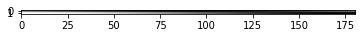

In [125]:
import math

#coords = np.array(image.shape[0], image.shape[1]) #1-400 array
#x, y = image.shape[0], image.shape[1]
def nk():
	n = 90 							# not sure
	r = 200 						# not sure
	plot = [[],[]]
	for alpha in range(90, 181):
		radiansAlpha = math.radians(alpha)
		xE = r * math.cos(radiansAlpha)
		yE = r * math.sin(radiansAlpha)
		for i in range(n):
			fi = 90/n  				# not sure
			xD = r * math.cos(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
			yD = r * math.sin(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
		plot[0].append(xE)
		plot[1].append(yE)
	plt.plot(plot, color="gray")
	plt.show()
print(plot)
showImage(plot)
